# CS 3110/5110: Data Privacy
## In-Class Exercise, week of 10/16/2023

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

In [2]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

## Question 1

Write a function to calculate the L1 **local sensitivity** of the following mean query.

In [3]:
def mean_query():
    b = 125
    return adult['Age'][adult['Education'] == 'Bachelors'].clip(lower=0, upper=b).mean()

mean_query()

38.90494864612511

In [4]:
def mean_query_local_sensitivity():
    b = 125
    return b / (len(adult['Age'][adult['Education'] == 'Bachelors']) + 1)

mean_query_local_sensitivity()

0.02333831217326363

In [5]:
# TEST CASE
assert (mean_query_local_sensitivity() - 0.02333831217326363) < 0.0001

## Question 2

Why can't we use the local sensitivity from question 1 directly to achieve differential privacy for `mean_query`?

The local sensitivity is also sensitive - by being a max value it could reveal information about the dataset. 

## Question 3

Implement an upper bound on $A(f, x, k)$, the local sensitivity of a mean query at distance $k$.

In [6]:
def ls_mean_at_distance(df, b, k):
    return np.abs(b/(len(df) - k))

In [7]:
# TEST CASE
assert ls_mean_at_distance(adult['Age'], 125, 500) == 0.0038988178784192633
assert ls_mean_at_distance(adult['Age'], 125, 5000) == 0.004535394216465295

## Question 4

Implement an upper bound on $D(f, x, s)$, the distance from $x$ to a database where the local sensitivity of the mean query is greater than or equal to $s$.

In [8]:
def dist_to_high_ls_mean(df, b, s):
    k = 0
    
    while ls_mean_at_distance(df, b, k) < s:
        k += 1
    
    return k

In [9]:
# TEST CASE
assert dist_to_high_ls_mean(adult['Age'], 125, 0.1) == 31311 
assert dist_to_high_ls_mean(adult['Age'], 125, 0.01) == 20061
assert dist_to_high_ls_mean(adult['Age'], 125, 0.001) == 0

## Question 5

Use the Propose-Test-Release (PTR) framework to calculate the mean age in the adult dataset with differential privacy.

In [10]:
def mean_ptr(epsilon, delta):
    clipped_ages = adult['Age'].clip(lower=0, upper=125)
    proposal = 0.005

    k = dist_to_high_ls_mean(clipped_ages, 125, proposal)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)
    #print(noisy_distance, threshold)

    if noisy_distance >= threshold:
        return laplace_mech(clipped_ages.mean(), proposal, epsilon)
    else:
        return None

mean_ptr(1.0, 10e-5)

38.57141699332863

In [11]:
# TEST CASE

true_answer = adult['Age'].mean()
trials = [mean_ptr(1.0, 10e-5) for _ in range(20)]
errors = [pct_error(true_answer, x) for x in trials]
assert np.mean(errors) < 1.0

## Question 6

Use the sample-and-aggregate framework to calculate the averge of ages in the adult dataset with differential privacy.

In [12]:
def saa_avg_age(k, epsilon):
    df = adult['Age']
    
    # Calculate the number of rows in each chunk
    chunk_size = int(np.ceil(df.shape[0] / k))
        
    # Step 1: split `df` into chunks
    xs      = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    
    # Step 2: run f on each x_i and clip its output
    answers = [x_i.mean() for x_i in xs]
    
    u = 80
    l = 20
    clipped_answers = np.clip(answers, l, u)
    
    # Step 3: take the noisy mean of the clipped answers
    noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
    return noisy_mean

saa_avg_age(600, 1)    

39.16996210649353

## Question 7

What is the impact of the parameter `k`?

- `k` is related to sensitivity and accuracy. As `k` goes up sensitivity decreases, but the chunks get smaller so accuracy also decreases. The inverse is also true.

## Question 8

Calculate the empirical *cumulative distribution function* of ages in the adult dataset. Use the RDP Gaussian mechanism.

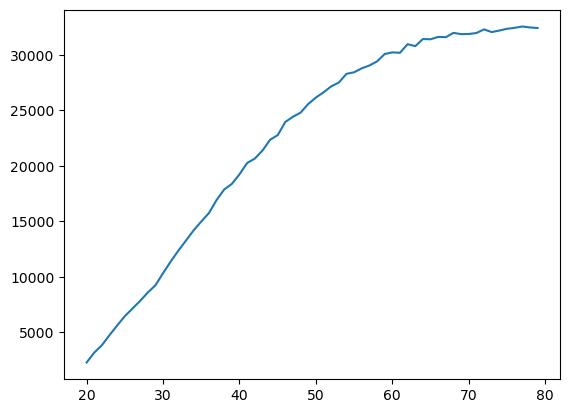

In [13]:
def calculate_cdf():
    alpha = 5
    epsilon = 0.0001
    
    cdf_vals = []
    for age in range(20, 80):
        count = len(adult[adult['Age'] <= age])
        noisy_count = gaussian_mech_RDP(count, 1, alpha, epsilon)
        cdf_vals.append(noisy_count)
    
    return cdf_vals

cdf_vals = calculate_cdf()
plt.plot(range(20, 80), cdf_vals);

## Question 9

What is the *total privacy cost* in RDP of your solution above?

The total privacy cost is $(\alpha, \bar\epsilon)$, where $\alpha = 5$ and $\bar\epsilon = 60 * 0.0001$, by sequential composition.

## Question 10

What is the *total privacy cost* in $(\epsilon, \delta)$-differential privacy of your solution above, for $\delta = 10^{-5}$?

The total privacy cost is $(\epsilon, \delta)$, where $\epsilon = 1.256$

## Question 11

Repeat question 3, but for zero-concentrated differential privacy.

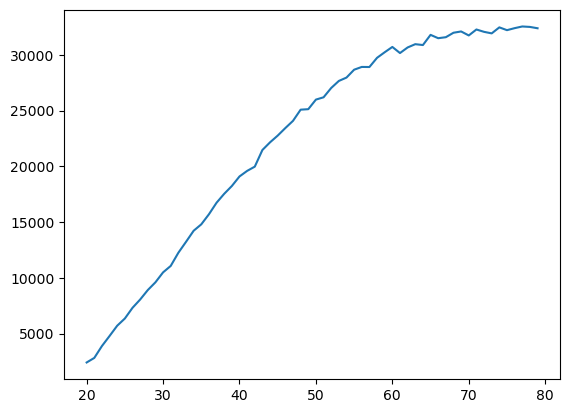

In [14]:
def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return val + np.random.normal(loc=0, scale=sigma)

def calculate_cdf_zcdp():
    rho = 0.00001
    
    cdf_vals = []
    for age in range(20, 80):
        count = len(adult[adult['Age'] <= age])
        noisy_count = gaussian_mech_zCDP(count, 1, rho)
        cdf_vals.append(noisy_count)
    
    return cdf_vals

cdf_vals = calculate_cdf_zcdp()
plt.plot(range(20, 80), cdf_vals);